In [4]:
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt

In [6]:
from utils import *

In [15]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
def get_cluster(workers=30,project = 'P93300641'):

    cluster = PBSCluster(
        cores=1, # The number of cores you want
        memory='10GB', # Amount of memory
        processes=1, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        local_directory='$TMPDIR', # Use your local directory
        resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
        account=project, # Input your project ID here
        walltime='01:30:00', # Amount of wall time
    )
    
    # Scale up
    cluster.scale(workers)
    
    # Setup your client
    client = Client(cluster)
    return client

In [10]:
def amean(da):
    #annual mean of monthly data
    m  = da['time.daysinmonth']
    cf = 1/365
    xa = cf*(m*da).groupby('time.year').sum().compute()
    return xa

In [16]:
client=get_cluster()

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.05s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


In [5]:
#locate the history files and read in the dataset
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h0'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1985
files = np.array(files)[yrs>=yr0]
def preprocess(ds):
    dvs=['TLAI','GPP','ER','SOILWATER_10CM','EFLX_LH_TOT','TV']
    return ds[dvs]
ds = xr.open_mfdataset(files,combine='nested',concat_dim='time',
                       decode_times=False,preprocess=preprocess)
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')

In [28]:
#locate the sparsegrids and read in the fullgrid landarea
d='/glade/u/home/forrest/ppe_representativeness/output_v4/'
files=np.array(glob.glob(d+'*annual+sd*'))
ix=np.argsort(np.array([f.split('.')[-2] for f in files]).astype(int))
files=files[ix]
tmp=xr.open_dataset(files[0])
la=tmp.area*tmp.landfrac

In [8]:
#function to compute global GPP from a given sparsegrid subsample
def get_gpp(file,gpp):
    sg=xr.open_dataset(file)
    xv=np.zeros([gpp.shape[0],len(sg.numclust)+1])+np.nan
    ix=sg.rcent.values[sg.rcent>0].astype(int)
    xv[:,ix]=gpp[:,sg.rcent>0]
    c=sg.cclass.values.ravel()
    c=c[c>0].astype(int)
    mapped=np.zeros(gpp.shape)+np.nan
    mapped[:,sg.cclass>0]=xv[:,c]
    out=xr.DataArray(mapped,dims=['year','lat','lon'])
    gppsg=gmean(out,la)
    return gppsg

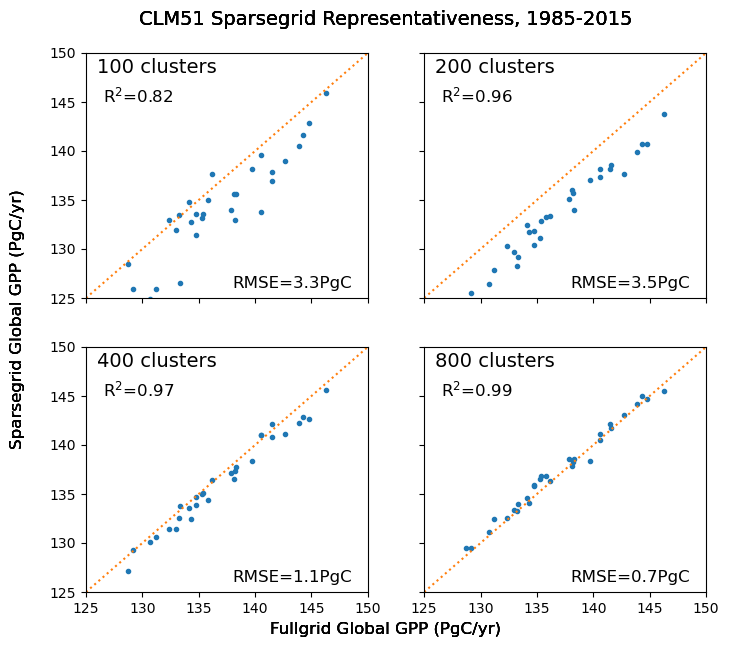

In [41]:
#final plot
gpp=24*60*60*365*amean(ds.GPP)
gppfg=1e-9*la.sum()*gmean(gpp,la)
fig=plt.figure(figsize=[8,7])

for i,file in enumerate(files[[5,7,10,-1]]):

    gppsg=la.sum()*1e-9*get_gpp(file,gpp.values)

    plt.subplot(2,2,i+1)
    plt.plot(gppfg,gppsg,'.')
    plt.plot([125,150],[125,150],':')
    plt.xlim([125,150])
    plt.ylim([125,150])
    c=file.split('.')[-2]
    
    
    rmse=str(np.round(np.sqrt(np.mean((gppfg-gppsg)**2)).values,1))
    r2=str(np.round(np.corrcoef(gppfg,gppsg)[0,1]**2,2))
    
    plt.text(126,148,c+' clusters',fontsize=14)
    plt.text(138,126,r'RMSE='+rmse+'PgC',fontsize=12)
    plt.text(126.5,145,r'R$^2$='+r2,fontsize=12)
    
    
    if (i%2)>0:
        plt.yticks(range(125,155,5),'')
        
    if i<2:
        plt.xticks(range(125,155,5),'')
        
        
 
    
    fig.text(0.5,0.92,'CLM51 Sparsegrid Representativeness, 1985-2015',fontsize=14,ha='center')
    fig.text(0.03,0.5,'Sparsegrid Global GPP (PgC/yr)',rotation='vertical',va='center',fontsize=12)
    fig.text(0.5,0.05,'Fullgrid Global GPP (PgC/yr)',ha='center',fontsize=12)
plt.savefig('figs/clm51sg_clm51sim_gpp.png',dpi=300,bbox_inches='tight')

In [22]:
#locate the history files and read in the dataset
d='/glade/derecho/scratch/oleson/archive/ctsm530_f19_PPE_hist/lnd/hist/'
tape='h0'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1985
files = np.array(files)[yrs>=yr0]
ds1 = xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                       decode_times=False,preprocess=preprocess)
ds1['time']=xr.cftime_range(str(yr0),periods=len(ds1.time),freq='MS',calendar='noleap')

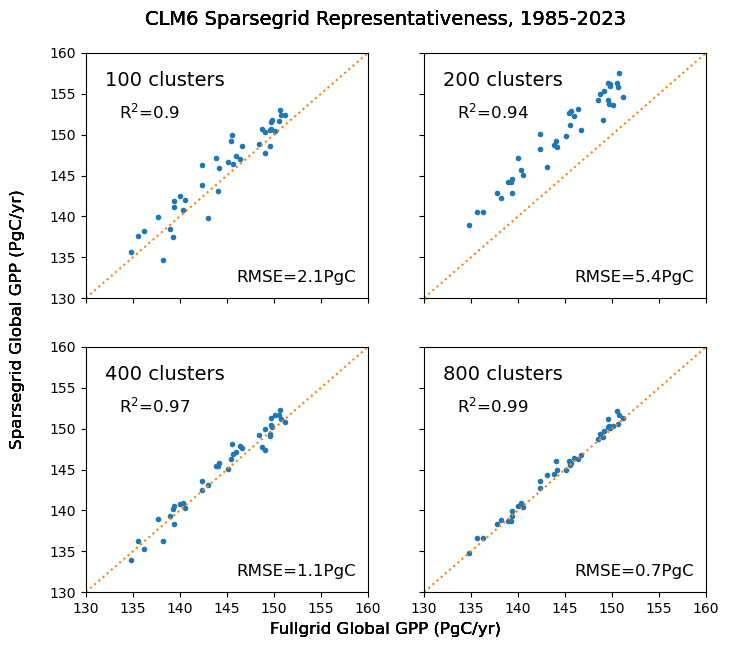

In [42]:
gpp=24*60*60*365*amean(ds1.GPP)
gppfg=1e-9*la.sum()*gmean(gpp,la)
fig=plt.figure(figsize=[8,7])

for i,file in enumerate(files[[5,7,10,-1]]):

    gppsg=la.sum()*1e-9*get_gpp(file,gpp.values)

    plt.subplot(2,2,i+1)
    plt.plot(gppfg,gppsg,'.')
    plt.plot([130,160],[130,160],':')
    plt.xlim([130,160])
    plt.ylim([130,160])
    c=file.split('.')[-2]
    
    
    rmse=str(np.round(np.sqrt(np.mean((gppfg-gppsg)**2)).values,1))
    r2=str(np.round(np.corrcoef(gppfg,gppsg)[0,1]**2,2))
    
    plt.text(132,156,c+' clusters',fontsize=14)
    plt.text(146,132,r'RMSE='+rmse+'PgC',fontsize=12)
    plt.text(133.5,152,r'R$^2$='+r2,fontsize=12)
    
    
    if (i%2)>0:
        plt.yticks(range(130,165,5),'')
        
    if i<2:
        plt.xticks(range(130,165,5),'')
        
        
 
    
    fig.text(0.5,0.92,'CLM6 Sparsegrid Representativeness, 1985-2023',fontsize=14,ha='center')
    fig.text(0.03,0.5,'Sparsegrid Global GPP (PgC/yr)',rotation='vertical',va='center',fontsize=12)
    fig.text(0.5,0.05,'Fullgrid Global GPP (PgC/yr)',ha='center',fontsize=12)
plt.savefig('figs/clm51sg_clm6sim_gpp.png',dpi=300,bbox_inches='tight')